In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# write open fits file muram.fits
import pandas as pd
from astropy.io import fits
from astropy.table import Table

data_raw = fits.open('muram_snapshot_for_david.fits')
data_raw.info()  # Print information about the FITS file


# smanji 1024 na manji deo 

Filename: muram_snapshot_for_david.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (70, 3, 1024, 5)   float64   


In [3]:
# transpose this data to have shape (x, y, z)
print(data_raw[0].data.shape)
print(data_raw[0].data[0, : , 0, :].shape)

(5, 1024, 3, 70)
(1024, 70)


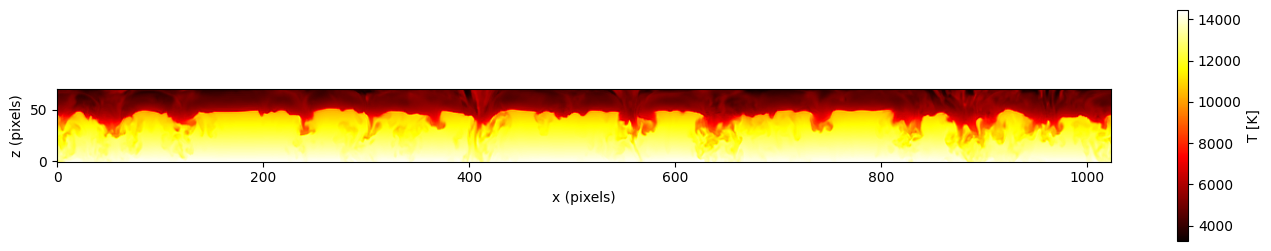

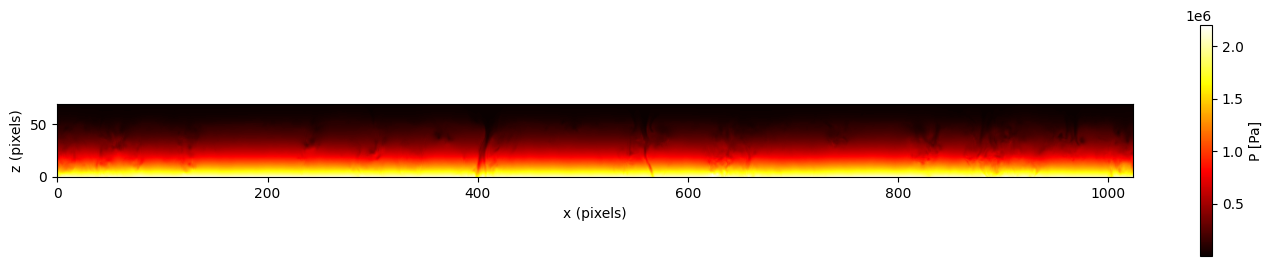

In [4]:
plt.figure(figsize=(17, 3))
plt.imshow(data_raw[0].data[0, :, 0, :].transpose(1,0), cmap='hot', origin='lower')
plt.xlabel('x (pixels)')
plt.ylabel('z (pixels)')
plt.colorbar(label = "T [K]")
plt.show()

plt.figure(figsize=(17.36, 3))
plt.imshow(data_raw[0].data[1, :, 0, :].transpose(1,0), cmap='hot', origin='lower')
plt.xlabel('x (pixels)')
plt.ylabel('z (pixels)')
plt.colorbar(label = "P [Pa]")
plt.show()

In [5]:
# Radicemo prvo samo sa jednim slojem y

T_sim = data_raw[0].data[0, 0:100, 0, :]
P_sim = data_raw[0].data[1, 0:100, 0, :]
   
np.shape(T_sim) 

(100, 70)

In [6]:
np.shape(P_sim[:,-1]) 

(100,)

In [7]:
class PINN(nn.Module):

    def __init__(self):
        super().__init__()
        layers = []
        sizes = [2] + [32] * 2 + [2]
        for i in range(len(sizes) - 1): # za svaki sloj
            layers.append(nn.Linear(sizes[i], sizes[i+1])) # linearna transformacija
            if i < len(sizes) - 2: # dodajem aktivaciju osim za izlazni sloj
                layers.append(nn.Tanh())
                
        self.net = nn.Sequential(*layers) # zvezdica da se razbije lista u argumente
        # Sequential kombinuje module u lanac

        for m in self.net: # uzima svaki modul iz sekvencijalnog modela
            if isinstance(m, nn.Linear): # samo linerarni slojevi imaju tezine i bias
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)


In [8]:
N_x = len(T_sim[: , 0])
N_z = len(T_sim[0 , :])

# Physical constants
m_sr = 1.23 * 1.66053906660e-27   # kg
k_b = 1.380649e-23               # J/K
g = 274.0                        # m/s^2
z_max = N_z * 24000              # m
x_max = N_x * 24000              # m

T0 = 6000.0
H0 = k_b * T0 / (m_sr * g)

x_sim = np.linspace(0, x_max, N_x)
z_sim = np.linspace(0, z_max, N_z)

X, Z = np.meshgrid(x_sim, z_sim, indexing="ij")  # (N_x, N_z)


X_flat = torch.from_numpy(X / x_max).float().reshape(-1, 1)
Z_flat = torch.from_numpy(Z / z_max).float().reshape(-1, 1)    
X_dom = torch.cat([X_flat, Z_flat], dim=1).requires_grad_(True)


# Top boundary (z = z_max)
x_top = torch.from_numpy(X[:, -1] / x_max).float().unsqueeze(1)
z_top = torch.ones_like(x_top)
X_top = torch.cat([x_top, z_top], dim=1)

print("X_dom:", X_dom.shape)
print("X_top:", X_top.shape)


P_top = P_sim[: , -1]            # Pa, pritisak na poslednjem sloju
#P_top_torch = torch.tensor(P_top, dtype=torch.float32, device=X_dom.device)

T_max = np.max(T_sim)

# NumPy → Torch, flatten to match X_dom
T_sim_flat = torch.from_numpy(np.ascontiguousarray(T_sim).astype(np.float32)).reshape(-1, 1).to(X_dom.device)

# Make sure P_top is float32 and contiguous
P_top_torch = torch.from_numpy(np.ascontiguousarray(P_top).astype(np.float32)).to(X_dom.device)  # put on same device (CPU/GPU)

X_dom: torch.Size([7000, 2])
X_top: torch.Size([100, 2])


In [9]:

model = PINN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Weights = [1.0, 1.0, 1.0, 1.0] # HSRz, HSRx, T, BCp


In [10]:

logP_top = torch.log(P_top_torch)

T_sim_flat_torch = torch.tensor(
    T_sim_flat,
    dtype=torch.float32,
    device=X_dom.device
)

def pinn_loss():
    # NN output
    Y = model(X_dom)
    logp = Y[:, 0:1]        # dimensionless pressure
    T_reduced = Y[:, 1:2]

    # Physical temperature
    T = (T_reduced + 1) * T_max

    # Gradients of p_tilde
    grads = torch.autograd.grad(
        logp, X_dom,
        grad_outputs=torch.ones_like(logp),
        create_graph=True
    )[0]

    dlogp_dx = grads[:, 0:1]
    dlogp_dz = grads[:, 1:2]

    # Scale height from simulation temperature
    H = (k_b * T_sim_flat_torch) / (m_sr * g)

    # --------------------
    # PDE residuals
    # --------------------
    loss1 = dlogp_dz + z_max/H    # hydrostatic
    loss2 = dlogp_dx               # x-independence

    # --------------------
    # Temperature loss
    # --------------------
    loss3 = (T - T_sim_flat_torch) / T_max

    # --------------------
    # Boundary condition (TOP): p_tilde = 0
    # --------------------
    logp_top_pred = model(X_top)[:, 0:1]
    bc_p = logp_top_pred - logP_top  # enforce exact top pressure


    # --------------------
    # Weighted MSE losses
    # --------------------
    L1 = Weights[0] * loss1.pow(2).mean()
    L2 = Weights[1] * loss2.pow(2).mean()
    L3 = Weights[2] * loss3.pow(2).mean()
    LP = Weights[3] * bc_p.pow(2).mean()

    total_loss = L1 + L2 + L3 + LP

    return total_loss, L1, L2, L3, LP


/tmp/ipykernel_663012/55962779.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_sim_flat_torch = torch.tensor(


In [11]:

"""    
def pinn_loss():
    Y = model(X_dom)
    logp = Y[:, 0:1]
    T_reduced = Y[:, 1:2]

    T = (T_reduced + 1) * T_max  # Scale T to physical range

    grads = torch.autograd.grad(
        logp, X_dom,
        grad_outputs=torch.ones_like(logp),
        create_graph=True
    )[0]

    dlogp_dx = grads[:, 0:1]
    dlogp_dz = grads[:, 1:2]

    H = (k_b * T_sim_flat) / (m_sr * g)

    loss1 = dlogp_dz + z_max / H
    loss2 = dlogp_dx

    # Loss3 Temp - T(X)
    loss3 = (T - T_sim_flat) / T_max

    # Boundary conditions
    # Bottom BC for logp: log(p) = log(p0)
    logp_bot = model(X_top)[:, 0:1]
    bc_p = logp_bot - torch.log(P_top_torch)

    # Mean-squared losses
    L1 = Weights[0]*loss1.pow(2).mean()
    L2 = Weights[1]*loss2.pow(2).mean()
    L3 = Weights[2]*loss3.pow(2).mean()
    LP = Weights[3]*bc_p.pow(2).mean()

    total_loss = L1 + L2 + L3 + LP

    return total_loss, L1, L2, L3, LP
"""

'    \ndef pinn_loss():\n    Y = model(X_dom)\n    logp = Y[:, 0:1]\n    T_reduced = Y[:, 1:2]\n\n    T = (T_reduced + 1) * T_max  # Scale T to physical range\n\n    grads = torch.autograd.grad(\n        logp, X_dom,\n        grad_outputs=torch.ones_like(logp),\n        create_graph=True\n    )[0]\n\n    dlogp_dx = grads[:, 0:1]\n    dlogp_dz = grads[:, 1:2]\n\n    H = (k_b * T_sim_flat) / (m_sr * g)\n\n    loss1 = dlogp_dz + z_max / H\n    loss2 = dlogp_dx\n\n    # Loss3 Temp - T(X)\n    loss3 = (T - T_sim_flat) / T_max\n\n    # Boundary conditions\n    # Bottom BC for logp: log(p) = log(p0)\n    logp_bot = model(X_top)[:, 0:1]\n    bc_p = logp_bot - torch.log(P_top_torch)\n\n    # Mean-squared losses\n    L1 = Weights[0]*loss1.pow(2).mean()\n    L2 = Weights[1]*loss2.pow(2).mean()\n    L3 = Weights[2]*loss3.pow(2).mean()\n    LP = Weights[3]*bc_p.pow(2).mean()\n\n    total_loss = L1 + L2 + L3 + LP\n\n    return total_loss, L1, L2, L3, LP\n'

In [12]:

epochs = 1000

history = {
    "epoch": [],
    "loss_total": [],
    "loss_dlogp_dz": [],
    "loss_dlogp_dx": [],
    "loss_T": [],
    "bc_p": [],
    "bc_T": [],
}

for epoch in range(epochs):
    optimizer.zero_grad()

    loss, L1, L2, L3, L4 = pinn_loss()
    loss.backward()
    optimizer.step()
    
    history["loss_total"].append(loss.item())

    if epoch % 100 == 0:
        history["epoch"].append(epoch)
        history["loss_dlogp_dz"].append(L1.item())
        history["loss_dlogp_dx"].append(L2.item())
        history["loss_T"].append(L3.item())
        history["bc_p"].append(L4.item())
        #history["bc_T"].append(L5.item())
    
        print(f"\nEpoch {epoch}")
        print(f"  total loss   : {loss.item():.3e}")
        print(f"  dlogp/dz     : {L1.item():.3e}")
        print(f"  dlogp/dx     : {L2.item():.3e}")
        print(f"  T loss       : {L3.item():.3e}")
        print(f"  BC logp      : {L4.item():.3e}")
        #print(f"  BC T         : {L5.item():.3e}")




Epoch 0
  total loss   : 1.559e+02
  dlogp/dz     : 8.810e+01
  dlogp/dx     : 7.180e-03
  T loss       : 3.737e-01
  BC logp      : 6.741e+01

Epoch 100
  total loss   : 8.727e+01
  dlogp/dz     : 5.016e+01
  dlogp/dx     : 1.012e+01
  T loss       : 1.768e-02
  BC logp      : 2.697e+01

Epoch 200
  total loss   : 1.225e+01
  dlogp/dz     : 7.159e+00
  dlogp/dx     : 5.082e-01
  T loss       : 8.905e-03
  BC logp      : 4.570e+00

Epoch 300
  total loss   : 3.829e+00
  dlogp/dz     : 3.315e+00
  dlogp/dx     : 9.068e-02
  T loss       : 1.212e-02
  BC logp      : 4.111e-01

Epoch 400
  total loss   : 2.859e+00
  dlogp/dz     : 2.665e+00
  dlogp/dx     : 5.830e-02
  T loss       : 1.129e-02
  BC logp      : 1.251e-01

Epoch 500
  total loss   : 2.460e+00
  dlogp/dz     : 2.344e+00
  dlogp/dx     : 3.902e-02
  T loss       : 1.079e-02
  BC logp      : 6.616e-02

Epoch 600
  total loss   : 2.212e+00
  dlogp/dz     : 2.120e+00
  dlogp/dx     : 3.043e-02
  T loss       : 1.076e-02
  BC lo

In [13]:

"""
optimizer2 = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,                # important: LBFGS needs larger lr
    max_iter=20,
    tolerance_grad=1e-9,
    tolerance_change=1e-9,
    history_size=100
)

epochs = 200


for epoch in range(epochs):

    losses = {}

    def closure():
        optimizer2.zero_grad()
        loss, L1, L2, L3, L4 = pinn_loss()
        loss.backward()

        # save for logging
        losses["total"] = loss
        losses["L1"] = L1
        losses["L2"] = L2
        losses["L3"] = L3
        losses["L4"] = L4

        return loss

    optimizer2.step(closure)

    if epoch % 100 == 0:
        print(f"\nEpoch {epoch}")
        print(f"  total loss   : {losses['total'].item():.3e}")
        print(f"  dlogp/dz     : {losses['L1'].item():.3e}")
        print(f"  dlogp/dx     : {losses['L2'].item():.3e}")
        print(f"  T loss       : {losses['L3'].item():.3e}")
        print(f"  BC logp      : {losses['L4'].item():.3e}")

"""


'\noptimizer2 = torch.optim.LBFGS(\n    model.parameters(),\n    lr=1.0,                # important: LBFGS needs larger lr\n    max_iter=20,\n    tolerance_grad=1e-9,\n    tolerance_change=1e-9,\n    history_size=100\n)\n\nepochs = 200\n\n\nfor epoch in range(epochs):\n\n    losses = {}\n\n    def closure():\n        optimizer2.zero_grad()\n        loss, L1, L2, L3, L4 = pinn_loss()\n        loss.backward()\n\n        # save for logging\n        losses["total"] = loss\n        losses["L1"] = L1\n        losses["L2"] = L2\n        losses["L3"] = L3\n        losses["L4"] = L4\n\n        return loss\n\n    optimizer2.step(closure)\n\n    if epoch % 100 == 0:\n        print(f"\nEpoch {epoch}")\n        print(f"  total loss   : {losses[\'total\'].item():.3e}")\n        print(f"  dlogp/dz     : {losses[\'L1\'].item():.3e}")\n        print(f"  dlogp/dx     : {losses[\'L2\'].item():.3e}")\n        print(f"  T loss       : {losses[\'L3\'].item():.3e}")\n        print(f"  BC logp      : {losses[

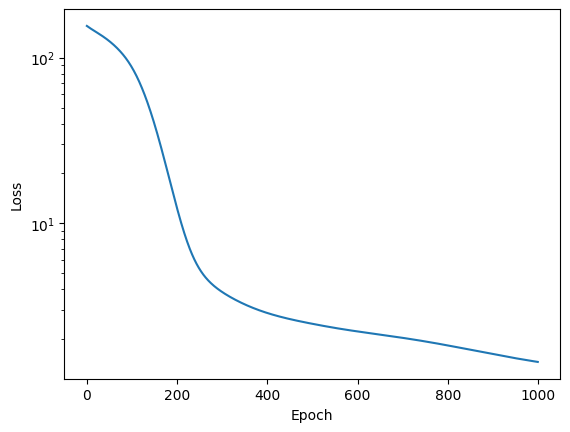

In [14]:
plt.semilogy(history["loss_total"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


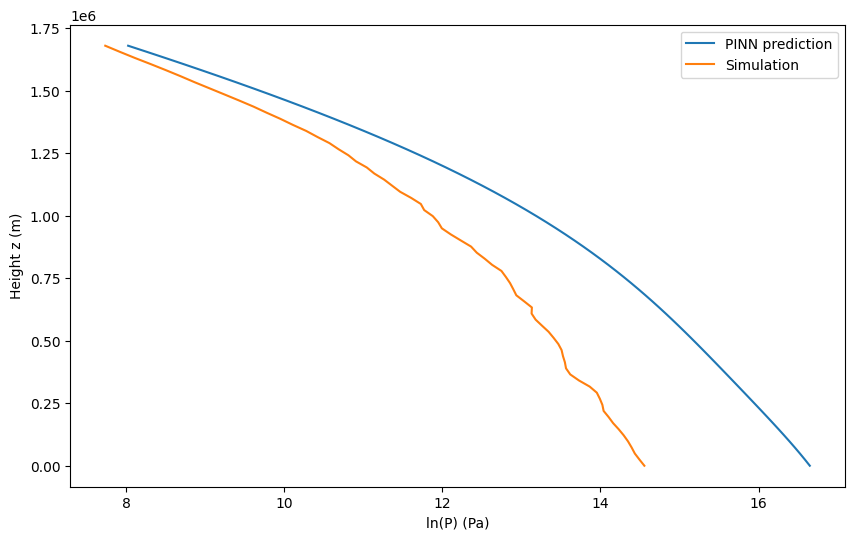

In [15]:
# Choose normalized x location
x_fixed_hat = 0.5   # normalized coordinate

# z from simulation (physical)
z_vec = z_sim.reshape(-1, 1)

# Build normalized input grid
x_vec_hat = np.full_like(z_vec, x_fixed_hat)
z_vec_hat = z_vec / z_max

XZ_tensor = torch.from_numpy(np.hstack([x_vec_hat, z_vec_hat])).float()


# Evaluate model
with torch.no_grad():
    # Direct NN output for log-pressure
    logp_pred = model(XZ_tensor)[:, 0:1]  


logp_pred = logp_pred.detach().cpu().numpy().squeeze()

# Find closest x-index in simulation
ix = np.argmin(np.abs(x_sim / x_max - x_fixed_hat))


# Plot
plt.figure(figsize=(10,6))
plt.plot(logp_pred, z_sim, label="PINN prediction")
plt.plot(np.log(P_sim[ix, :]), z_sim, label="Simulation")
plt.xlabel("ln(P) (Pa)")
plt.ylabel("Height z (m)")
plt.legend()
plt.show()


In [16]:
print("z_sim shape:", z_sim.shape)
print("logp_pred shape:", logp_pred.shape)
print("P_sim slice shape:", P_sim[ix, :].shape)

np.shape(logP_top)

z_sim shape: (70,)
logp_pred shape: (70,)
P_sim slice shape: (70,)


torch.Size([100])

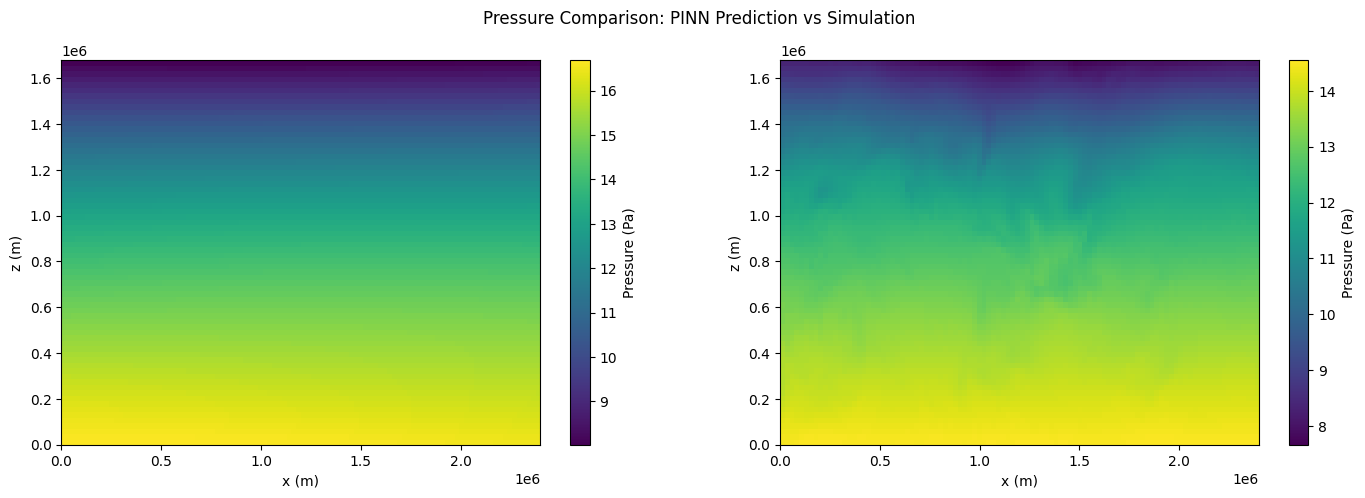

In [17]:
# Plot P from simulation and PINN for all x and z
logP_pred_all = model(X_dom)[:,0].detach().numpy().reshape(N_x, N_z)

fig, ax = plt.subplots(1, 2, figsize=(17,5))
ax[0].imshow(logP_pred_all.transpose(1,0))
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('z (m)')
fig.colorbar(ax[0].imshow(logP_pred_all.transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='viridis'), label='Pressure (Pa)')

ax[1].imshow(np.log(P_sim))
ax[1].set_xlabel('x (m)')
ax[1].set_ylabel('z (m)')
fig.colorbar(ax[1].imshow(np.log(P_sim).transpose(1,0), extent=[0, x_max, 0, z_max], aspect='auto', origin='lower', cmap='viridis'), label='Pressure (Pa)')
plt.suptitle('Pressure Comparison: PINN Prediction vs Simulation')
plt.show()
# plot P from simulation


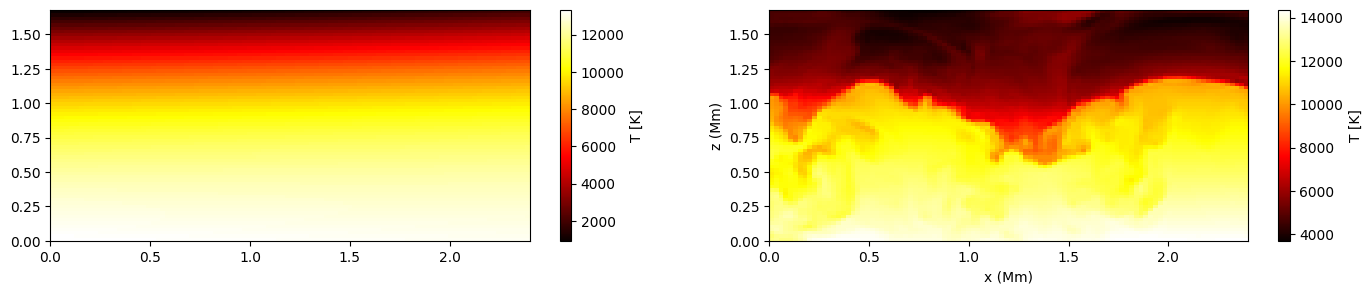

In [18]:
# I want to plot T from the model for all x and z
XZ_full = torch.cat([X_flat, Z_flat], dim=1).float()
T_pred_full = model(XZ_full)[:,1]
T_pred_full = (T_pred_full + 1) * T_max  # Scale T to physical range
T_pred_full = T_pred_full.detach().numpy().reshape(N_x, N_z)

fig, ax = plt.subplots(1, 2, figsize = (17,3))
ax[0].imshow(T_pred_full.transpose(1,0))
fig.colorbar(ax[0].imshow(T_pred_full.transpose(1,0), extent=[0, x_max/1e6, 0, z_max/1e6], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")


# next to it plot T from the simulation for all x and z
ax[1].imshow(T_sim.transpose(1,0))
fig.colorbar(ax[1].imshow(T_sim.transpose(1,0), extent=[0, x_max/1e6, 0, z_max/1e6], aspect='auto', origin='lower', cmap='hot'), label = "T [K]")
plt.xlabel('x (Mm)')
plt.ylabel('z (Mm)')
plt.show()  